<a href="https://colab.research.google.com/github/lucywowen/csci547_ML/blob/main/examples/anomaly_detection_with_guassian_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, recall_score, precision_score, average_precision_score, roc_auc_score, f1_score
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use('ggplot')

The following examples is based on [this](https://towardsdatascience.com/the-basics-of-anomaly-detection-65aff59949b7) article.

# What is anomaly detection?
In general terms, anomaly detection refers to the process of identifying phenomena that is out of ordinary. The goal of anomaly detection is to identify events, occurrences, data points, or outcomes that are not in line with our expectations and do not fit some underlying pattern. Hence, the key to implementing anomaly detection is to understand the underlying pattern of expected events. If we know the pattern of the expected, we can use it to map the never-before-seen data points; if our mapping is not successful and our new data point falls outside of our expected pattern, it’s probable that we have found our anomaly.

There are three types of anomalies that typically occur. First type includes individual instances which are considered anomalous with respect to the entire dataset (e.g., an individual car driving at very low speed on a highway is anomalous compared to all highway traffic). Second type includes instances which are anomalies within a specific context (e.g., credit card transactions which appear OK when compared to all credit card transactions but are anomalous for the specific individual’s spending pattern). Third type of anomalies is collective — a set of instances may be considered anomalous even though each instance on its own follows a certain expectation (e.g., a single fraudulent credit card transaction on Amazon may not seem out of ordinary but a set of transactions that take place back to back in a short amount of time is suspicious) [1].

Anomaly detection techniques fall into three categories:

- Supervised detection requires positive and anomalous labels in the dataset. Supervised learning algorithms like neural networks or boosted forests can be applied to categorize data points into expected/anomaly classes. Unfortunately, anomaly datasets tend to be very imbalanced and generally do not have enough training samples to allow up or downsampling techniques to aid the supervised learning.
- Semi-supervised detection deals with data that is partially labeled. Semi-supervised techniques assume that the input data only contains positive instances and that the input data follows an expected pattern. These techniques attempt to learn the distribution of positive cases in order to be able to generate positive instances. During testing, the algorithm will evaluate the likelihood that the anomalous instance could have been generated by the model and uses this probability to predict anomalous cases.
- Unsupervised detection uses completely unlabeled data in order to create a boundary of expectation and anything that falls outside of this boundary is considered to be anomalous.
Anomaly detection techniques can be applied to any data and data format impacts which algorithm will be most useful. Types of data include series (time series, linked list, language, sound), tabular (e.g., engine sensor data), image (e.g., X-ray images), and graph (e.g., workflow or process).

## Example of Anomaly Detection inchest X-ray images

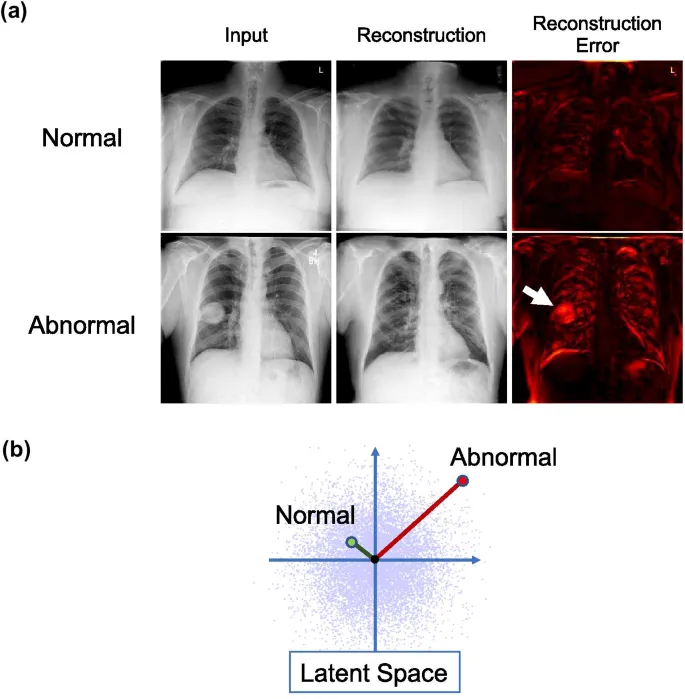



Example of anomaly detection in chest X-ray images

Given the variety of problems and techniques, anomaly detection is actually a vast area of data science with many applications. Some of these applications include: fraud detection, cybersecurity applications, analysis of sales or transactional data, identification of rare diseases, monitoring of manufacturing processes, exoplanet search, machine learning preprocessing, and many more. Therefore, access to powerful and performant algorithms has the potential to make significant impact in many fields.

Let’s take a look how at the most basic algorithm that can be used to detect anomalies.

## Gaussian Distribution for Anomaly Detection
One of the basic anomaly detection techniques employs the power of Gaussian (i.e. Normal) distribution in order to identify outliers.

Discovered by Carl Friedrich Gauss, Gaussian distribution models many natural phenomena and is, therefore, a popular choice for modeling features in a dataset. This distribution’s probability density function is a bell curve centered at the arithmetic mean and the width of the curve is defined by the variance of the dataset. With the majority of the cases being at or near the center, the probability density function features two elongated tails on each end. The more rare the instance — the further it is from the center — the more likely it is to be an outlier or an anomaly. Eureka!— we can use this concept to model anomalies in our dataset.

The probability density function, defined as f(x), measures the probability of some outcome x in our dataset. Formally,
$$f(x) = \frac{1}{\sigma \sqrt{2\pi}} \; \mathrm{exp}\bigg(-\frac{1}{2} \bigg( \frac{x-\mu}{\sigma} \bigg)^2 \bigg)$$

A Guassian distribution with $\mu = 0$ and $\sigma = 1$ is called the Standard Normal distribution.

Let's take a look at what this distribution looks like.


In [ ]:
def gaussian(x, mean=0, stdev=1):
    """ Gaussian distribution function, given mean and standard deviation.
    For standard normal distribution, mean is 0 and standard deviation is 1.

    Arguments:  x: float or int or list or numpy array
                mean: float or int, mean of the distribution
                stdev: standard deviation of the distribution (sqrt of variance)

    Returns:    numpy array, probability density value for a given x input value
    """

    # change type of x to be numpy array
    if type(x) != np.array:
        x = np.array(x)

    # calculate the formula
    f_x = np.multiply(
        np.divide(1, (np.multiply(stdev, np.sqrt(2*np.pi)))),
        np.exp(np.multiply(-0.5, np.square(np.divide(x - mean, stdev))))
    )

    return f_x


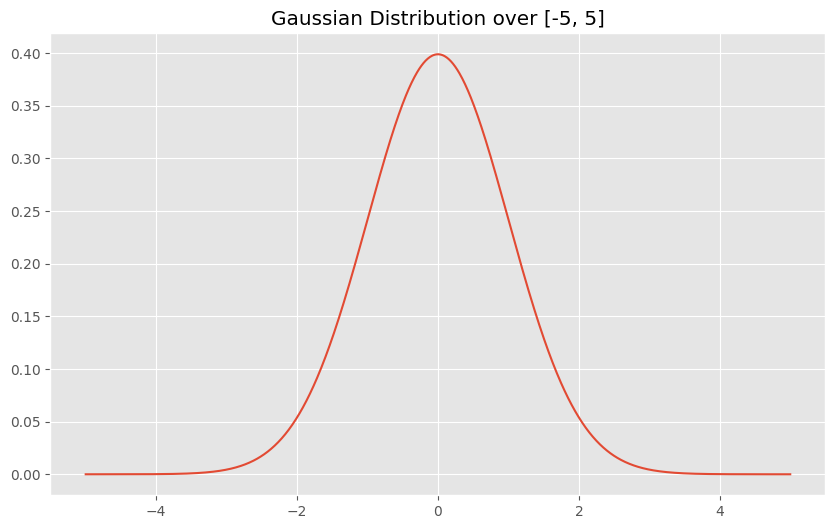

In [ ]:
# generate 1000 evently distributed values in range [-5, 5]
x = np.linspace(-5, 5, num=1000)

# plot results of the Gaussian function over x
plt.figure(figsize=(10, 6))
plt.plot(x, gaussian(x, 0, 1))
plt.title("Gaussian Distribution over [-5, 5]")
plt.show()


In a normal distribution, 2.5% of instances occur two standard deviations below the mean value. So if we set our threshold to 0.054, then about 2.5% of events in our dataset will be classified as anomalies (CDF of 2 standard deviations below the mean is 2.5 and PDF at -2 is 0.054). Lower thresholds will yield fewer classified anomalies and higher thresholds will be less sensitive.

In real world, there is likely to be a tradeoff as some of positive cases may fall below the threshold and some of the anomalies may hide above the threshold. It will be necessary to understand the use case and test different epsilon values before settling on the one that is best suited.

An example with a single feature is trivial — what do we do if we have more than one feature? If our features are completely independent, we can actually take the product of the feature probability density function in order to classify anomalies.

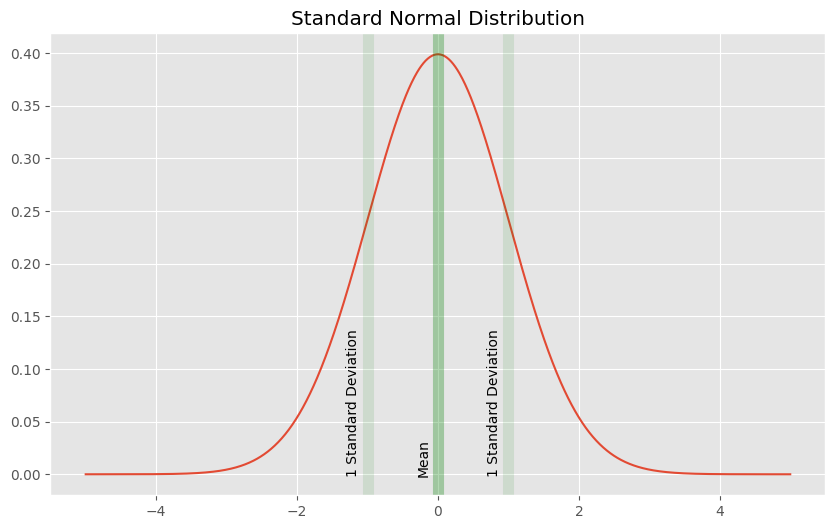

In [ ]:
# generate 1000 evently distributed values in range [-5, 5]
x = np.linspace(-5, 5, num=1000)


# plot results of the Gaussian function over x
plt.figure(figsize=(10, 6))
plt.plot(x, stats.norm(0, 1).pdf(x)) ## don't have to define our own gaussian, use scipy stats instead
plt.axvline(0, c='green', alpha=0.3, lw=8)
plt.annotate("Mean", (-0.3, 0), rotation=90)
plt.axvline(1, c='green', alpha=0.1, lw=8)
plt.annotate("1 Standard Deviation", (0.7, 0), rotation=90)
plt.axvline(-1, c='green', alpha=0.1, lw=8)
plt.annotate("1 Standard Deviation", (-1.3, 0), rotation=90)
plt.title("Standard Normal Distribution")
plt.show()

If we define an anomaly as a rare event, then we can use the probability density function to determine a threshold for an anomaly. If the probability of our event happens to be lower than our threshold, the event can be considered a potential anomaly.

Then, for a multivariate problem, we can multiply probabilities of all variables together to get the final probability of our event. If our event is unlikely, then it will be an outlier for at least one feature and if it is an outlier for many features, the result will near 0.

Let's take a look at an example with two variables. Let's define our distribution $f(x_1, x_2)$ to be the product of both probability density functions: $f_1(x_1)$ and $f_2(x_2)$. We assume that $x_1$ and $x_2$ are completely independent and have no correlation. Then,
$$
\begin{align}
f(x_1, x_2) & = f_1(x_1) \; f_2(x_2) \\
& = \frac{1}{\sigma_1 \sqrt{2\pi}} \; \mathrm{exp}\bigg(-\frac{1}{2} \bigg( \frac{x_1-\mu_1}{\sigma_1} \bigg)^2 \bigg)
    \frac{1}{\sigma_2 \sqrt{2\pi}} \; \mathrm{exp}\bigg(-\frac{1}{2} \bigg( \frac{x_2-\mu_2}{\sigma_2} \bigg)^2 \bigg) \\
& = \frac{1}{2\pi \; \sigma_1 \sigma_2}  \;
    \mathrm{exp}\bigg( \frac{1}{4} \bigg( \frac{x_1-\mu_1}{\sigma_1} \bigg)^2 \bigg( \frac{x_2-\mu_2}{\sigma_2} \bigg)^2  \bigg)
\end{align}
$$

Essentially, the product of probabilities of features can ensure that if at least one feature has an outlier, we can detect an anomaly (given that our epsilon is high enough); if our instance exhibits an outlier value in several features, our probability will be even smaller (since our total probability value is a product of fractions) and a value is even more likely to be an anomaly.

For the purposes of our class, that's all you need to know!  But in case you're wondering about violations of that indepence assumption, you can explore that more below:


### Violating independence assumption

We can't assume that the two distributions are totally uncorrelated and we should find their coefficient of correlation and account for it. If we assume that the two distribution are correlated, we can define their correlation coefficient as $\rho$. In the bivarirate and multivariate cases, we must not assume that the distribution may be correlated with correlation coefficient of $\rho$. If $x_1$ and $x_2$ are not correlated, then $\rho = 0$ and $f(x_1, x_2) = f_1(x_1) \; f_2(x_2)$. Otherwise,

$$
f(x_1, x_2) = \frac{1}{2\pi \sqrt{1-\rho^2} \sigma_1 \sigma_2}
                \mathrm{exp} \bigg( -\frac{1}{2 (1-\rho^2)} \bigg[
                    \bigg( \frac{x_1 - \mu_1}{\sigma_1} \bigg)^2  - 2\rho \bigg( \frac{x_1 - \mu_1}{\sigma_1} \bigg) \bigg( \frac{x_2 - \mu_2}{\sigma_2} \bigg) + \bigg( \frac{x_2 - \mu_2}{\sigma_2} \bigg)^2
                    \bigg]
                \bigg)
$$


Whew! I'm not going to prove it but these wonderful [lecture slides](https://www2.stat.duke.edu/courses/Spring12/sta104.1/Lectures/Lec22.pdf) from Duke university have a detailed derivation of bivariate and multivaraite cases.

And the multivariate case looks like this:

$$
f(x_1, ..., x_n) = \frac{-(\mathbf{x} - \bm{\mu})^\mathrm{T} \mathbf{\Sigma}^{-1} (\mathbf{x} - \bm{\mu})}{\sqrt{(2 \pi)^n | \mathbf{\Sigma} |}}
$$

In [ ]:
# generate 100 random features from normal distribution and 5 "anomalies" from uniform distribution
x1 = np.concatenate([np.random.normal(10, 5, size=100)])
x2 = np.concatenate([np.random.normal(18, 2, size=100)])

# calculate actual means and standard deviations from our feature sets
means = np.mean([x1, x2], axis=1)
stdevs = np.std([x1, x2], axis=1)

# create a multivariate distribution given our means and standard deviations
dist = stats.multivariate_normal(means, stdevs)

# add anomalies to the dataset (points that would not be in the normal distribution)
x1 = np.append(x1, [1, 1.5, 20, 21, 19])
x2 = np.append(x2, [25, 3, 2.1, 7, 3])

# calculate probability density values for our features
proba = dist.pdf(np.array([x1, x2]).T)

## Two-feature Model Implementation in Python
First, let’s observe a two-feature example which will allow us to visualize anomalies in Eucledian space. For this example, I generated two features with 100 samples drawn from the Normal distribution (these are the positive samples). I calculated feature means and standard deviations and fit a multivariate normal model from the scipy.stats library with the distribution information. Of note: I fit my model with positive samples only. In real-world data, we want to clean our dataset to ensure that the features follow normal distribution and do not contain outliers or odd values — this will improve models ability to locate anomalies (especially since it will help ensure the feature Normal distribution requirement). Finally, I added 5 anomalous samples to my dataset and use the .pdf method to report the probabilities.

The following scatterplot shows the result: x1 feature is plotted on the x-axis, x2 feature is plotted on the y-axis, anomalies are annotated, and the color represents the probability from the multivariate probability density function.

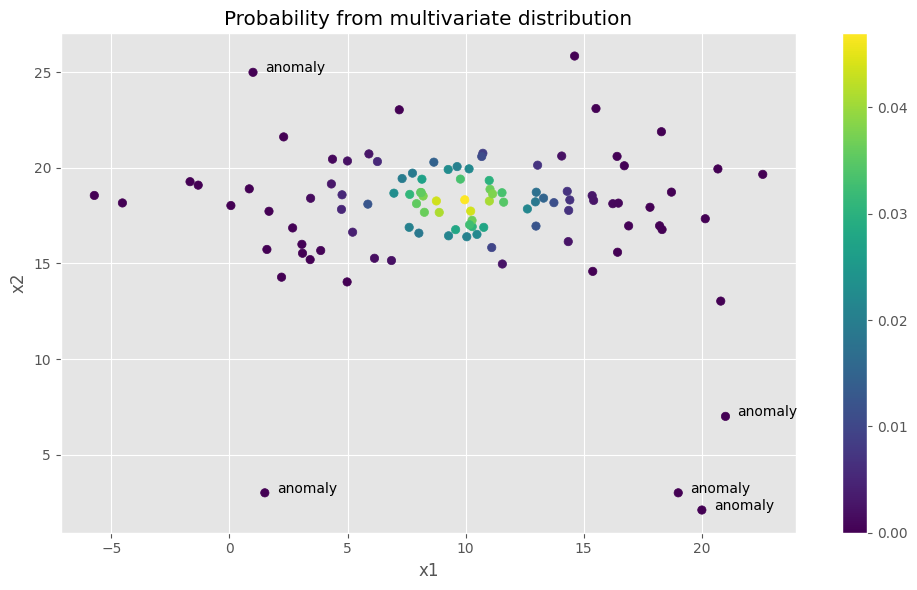

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x1, x2, c=proba)
plt.title(f"Probability from multivariate distribution")
plt.xlabel("x1")
plt.ylabel("x2")
for i in range(5):
    plt.annotate("anomaly", (x1[-(i+1)]+0.5, x2[-(i+1)]))
plt.colorbar()
plt.tight_layout()
plt.show()

Once we set our threshold low enough, we will be able to distinguish the anomalies from the expected values. Two charts below compare epsilon values between 1x10^-7 and 1x10^-9. Epsilon value of 1x10^-9 tends to capture our intended outliers better while 1x10^-7 identifies some positive samples as outliers.

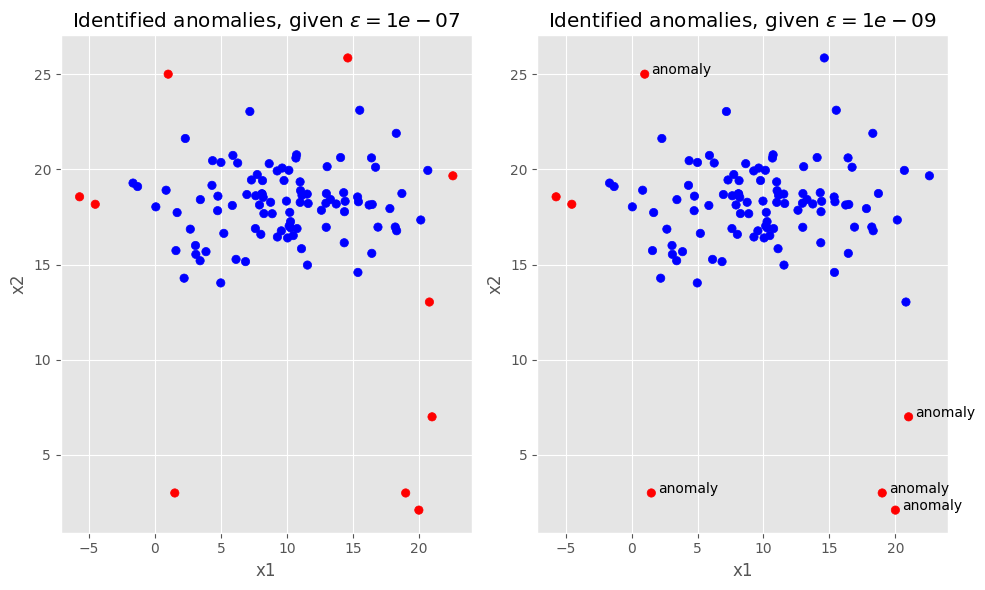

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

eps = 1e-7
ax1.scatter(x1, x2, c=np.where(proba<eps, "red", "blue"))
ax1.title.set_text(f"Identified anomalies, given $\epsilon = {eps}$")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

eps = 1e-9
ax2.scatter(x1, x2, c=np.where(proba<eps, "red", "blue"))
ax2.title.set_text(f"Identified anomalies, given $\epsilon = {eps}$")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")

for i in range(5):
    plt.annotate("anomaly", (x1[-(i+1)]+0.5, x2[-(i+1)]))
plt.tight_layout()
plt.show()

Let's explore a real dataset.

Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.   
Aeberhard,Stefan and Forina,M.. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J.

## Multivariate Model Implementation with Python
For this example, I will use the wine dataset from ODDS library (see above). This dataset contains 13 numerical features and 129 instances. The features capture information about the wine and the original dataset was used for classification tasks based on wine analysis. For the purpose of anomaly detection, one of the target classes was downsampled and is presented as an outlier. There are total of 10 anomalies among 129 instances (~8%). We are working with a fairly clean dataset with no missing values.

The very first thing we must do is ensure that our features follow a Gaussian distribution. Where possible, we should remove outliers and normalize the distribution using one of normalization tactics. In this dataset, 4 features already follow a normal distribution (alcohol, ash, alcalinity of ash, and non-flavanoid phenols) and 4 features can be normalized by taking their log (total phenols, proanthocyanins, color intensity, and hue). While better strategies exist for the remaining features, for the purpose of this exercise I simply dropped them from our training dataset. Finally, I removed the outliers by excluding all rows that contain at least one feature value that is above or below 2 standard deviations from the mean. The remainder of the code is the same as in the example above.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving wine.mat to wine.mat


In [ ]:
# upload the datafile
# http://odds.cs.stonybrook.edu/wine-dataset/
# Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.
wine = loadmat('wine.mat')

# grab the features and create a dataframe
columns = ["alcohol", "malicacid", "ash", "alcalinity_of_ash", "magnesium",
          "total_phenols", "flavanoids", "nonflanoid_phenols", "proanthocyanins",
          "color_intensity", "hue", "0D280_0D315_of_diluted_wines", "proline"]

df = pd.DataFrame(wine["X"])
df.columns = columns

# anomaly targets
y_true = wine["y"].flatten()

# include features that follow a normal distribution
# this is tested using the Shapiro-Wilk test for normality
features = [c for c in columns if stats.shapiro(df[c]).pvalue >= 0.01]

# log scale columns to normalize them
for c in ['total_phenols', 'proanthocyanins', 'color_intensity', 'hue']:
    df[c] = np.log(df[c]+1)
    features.append(c)

# identify outliers and exclude them from the training set
df['outlier'] = 0
for f in features:
    df['outlier'] += ((df[f] > df[f].mean()+2*df[f].std()) | (df[f] < df[f].mean() - 2*df[f].std())).astype(int)

df_train = df[df['outlier']==0]

# create a multivariate distribution given our means and standard deviations
dist = stats.multivariate_normal(df_train[features].mean().to_numpy(), df_train[features].std().to_numpy())

# calculate probability density values for our features for ALL values
proba = dist.pdf(df[features].to_numpy())


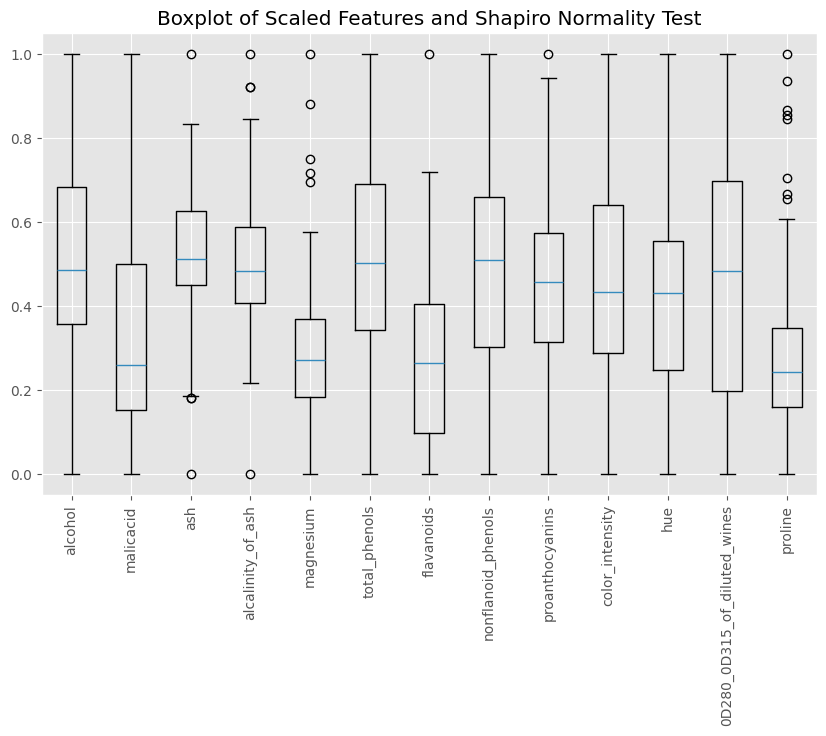

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(minmax_scale(df[columns]))
plt.xticks(ticks=list(range(1, len(columns)+1)), labels=columns, rotation=90)
plt.title("Boxplot of Scaled Features and Shapiro Normality Test")
plt.show()


Unlike the two-feature example from the section above, it is no longer feasible to visualize the results on a 2-dimensional plane but we can use confusion matrix metrics (including recall and precision) and ROC area under the curve to help us find the correct epsilon for the use-case.

As there is usually a tradeoff between precision and recall, the setting of epsilon depends on the sensitivity requirement of our use case. For this example, I looked for an epsilon that maximizes the area under the curve. Some use cases may call for trying to find as many anomalies as possible (at the cost of including positive values) while other use-cases may call for only detecting anomalies if we are absolutely sure (at the cost of missing some anomalies from our final report). I calculated evaluation metrics for several different epsilon values.

In [ ]:
# evaluate the model with different epsilon values

eps = np.linspace(0.001, 0.01, 21)
recall = []
precision = []
auc = []
f1 = []

for e in eps:
    y_pred = np.where(proba < e, 1, 0)
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    auc.append(roc_auc_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred))

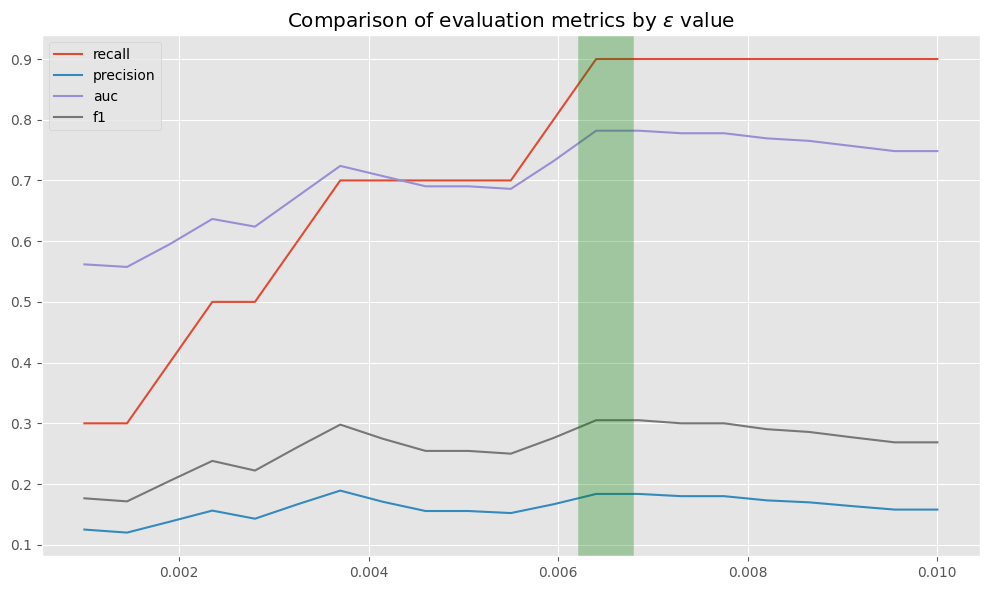

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(eps, recall, label='recall')
plt.plot(eps, precision, label='precision')
plt.plot(eps, auc, label='auc')
plt.plot(eps, f1, label='f1')
plt.axvline(0.0065, c='green', alpha=0.3, lw=40)
plt.title('Comparison of evaluation metrics by $\epsilon$ value')
plt.legend()
plt.tight_layout()
plt.show()

Let's set epsilon to 0.0065 and calculate the confusion matrix

In [ ]:
y_pred = np.where(proba < 0.0065, 1, 0)

cm = pd.DataFrame(confusion_matrix(y_true, y_pred),
                  columns=['Predicted Positive', 'Predicted Anomaly'],
                  index=['True Positive', 'True Anomaly'])

print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))


╒═══════════════╤══════════════════════╤═════════════════════╕
│               │   Predicted Positive │   Predicted Anomaly │
╞═══════════════╪══════════════════════╪═════════════════════╡
│ True Positive │                   79 │                  40 │
├───────────────┼──────────────────────┼─────────────────────┤
│ True Anomaly  │                    1 │                   9 │
╘═══════════════╧══════════════════════╧═════════════════════╛


As there is usually a tradeoff between precision and recall, the setting of epsilon depends on the sensitivity requirement of our use case. For this example, I looked for an epsilon that maximizes the area under the curve. Some use cases may call for trying to find as many anomalies as possible (at the cost of including positive values) while other use-cases may call for only detecting anomalies if we are absolutely sure (at the cost of missing some anomalies from our final report). I calculated evaluation metrics for several different epsilon values.

As epsilon increases, recall increases. Precision is fairly low throughout the proposed epsilon values but tends to peak around 0.0035 and 0.0065. The AUC attempts to strike the balance between precision and recall and has a peak around 0.0065. Let’s take a look at the confusion matrix.

Our model does quite well at finding all of the anomalies and only misses one. This is a fantastic result given that I excluded a third of the features. Unfortunately, our model also shows 40 positive instances as anomalies which means that if we use the model for anomaly detection, we would have to manually check half of positive instances to see if they were actually anomalous.

To improve this model we can further engineer the remaining features and find an epsilon values that may be a bit less sensitive to outliers.  

## Potential Drawbacks with Gaussian Anomaly Detection
Multivariate Gaussian distribution is a great model for anomaly detection — it is simple, fast, and easy to execute. However, its drawbacks can prevent its utilization for numerous use cases.

- First, multivariate distribution can produce fairly low probability density values. Generally, this is not a problem for modern computers. But there may be instances where the values are too low to be effectively handled by a computer.

- Second, we must ensure that our features follow a normal distribution. This may not be too much of an issue if time and effort is dedicated to perform proper feature engineering and data manipulation but putting effort is risky since we won’t know the payout until we do the work.

- Third, this model does not handle categorical features and if our dataset includes categorical features, we must create a separate model per each combination of categorical features (which can turn out to be a lot of work).

- Finally, the model assumes that all features are equally relevant and there is no complex relationship between the features. One option to deal with this is to implement the multivariate distribution probability density function from scratch and include some parameter to help with feature importance. To resolve the issue with feature relationships, we could do further feature engineering and create new features but this process can be difficult, time-consuming, and risky (in terms of payout).

Nonetheless, the use of multivariate Gaussian distribution for anomaly detection is a great first step for tabular anomaly detection problems. It can be used to set a benchmark or can prove to be a perfect tool for catching anomalies in a dataset and provides for us an intuitive way to understand anomaly detection.

